# 5 Minute Tutorial

Show an example use case of `niftidataset`

## Setup notebook

In [22]:
from glob import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
from torch import nn
import torchvision.transforms as torch_tfms

 Support in-notebook plotting

In [2]:
%matplotlib inline

Report versions

In [3]:
print('numpy version: {}'.format(np.__version__))
from matplotlib import __version__ as mplver
print('matplotlib version: {}'.format(mplver))

numpy version: 1.15.4
matplotlib version: 3.0.2


In [4]:
pv = sys.version_info
print('python version: {}.{}.{}'.format(pv.major, pv.minor, pv.micro))

python version: 3.7.3


Reload packages where content for package development

In [5]:
%load_ext autoreload
%autoreload 2

## Define test images

In [9]:
data_dir = '../tests/test_data/nii/'

## Setup a niftidataset class

In [10]:
from niftidataset import *

In [11]:
tfms = torch_tfms.Compose([RandomCrop2D(32, None), ToTensor()])
ds = NiftiDataset(data_dir, data_dir, tfms)

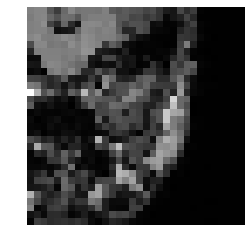

In [15]:
src,tgt = ds[0]
plt.imshow(np.rot90(src[0]), cmap='gist_gray')
plt.axis('off');

Note that this image is a very downsampled image from the publicly available [Kirby 21](https://www.nitrc.org/projects/multimodal) dataset.

In [59]:
fns = glob('../tests/test_data/tif/*.tif')
im = Image.open(fns[0])

In [64]:
def nm(x): 
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min())
def show(x,ax): ax.imshow(x,cmap='gray'); ax.axis('off');

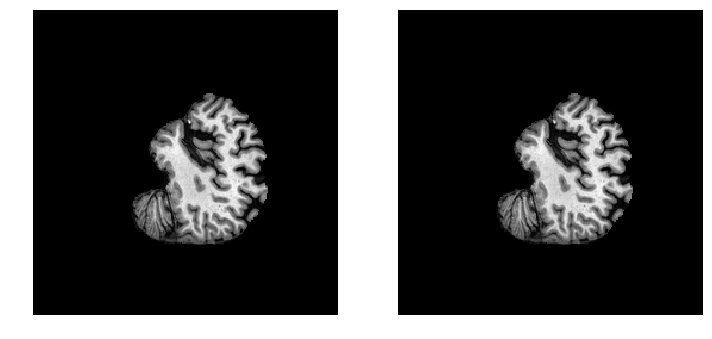

In [65]:
xn = yn = nm(im)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn,ax1);show(yn,ax2)

### Random affine transform

In [86]:
af = RandomAffine(1., 45., 0.1, 0.3)

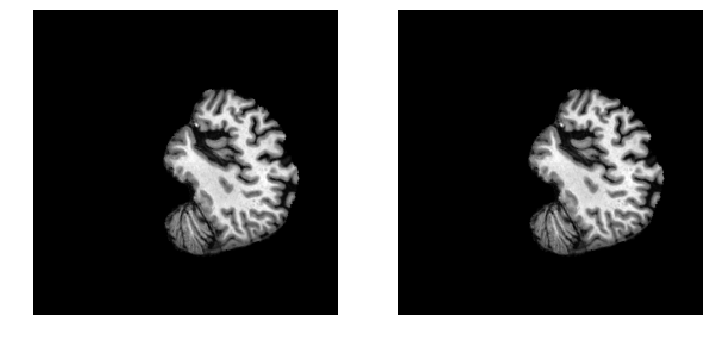

In [87]:
xn, yn = af((im,im))
xn, yn = nm(xn), nm(yn)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn,ax1);show(yn,ax2)

### Random flip transform

In [88]:
fl = RandomFlip(0.5, True, True)

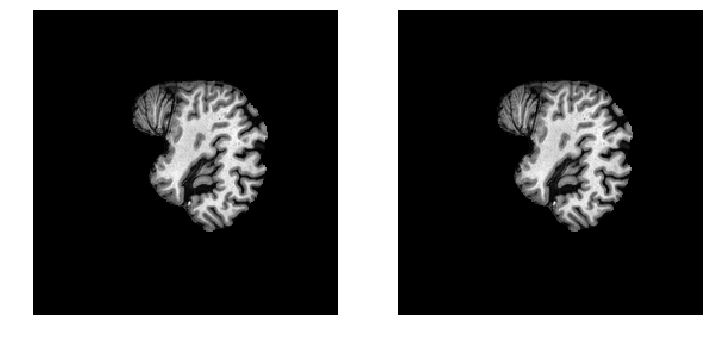

In [89]:
xn, yn = fl((im,im))
xn, yn = nm(xn), nm(yn)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn,ax1);show(yn,ax2)

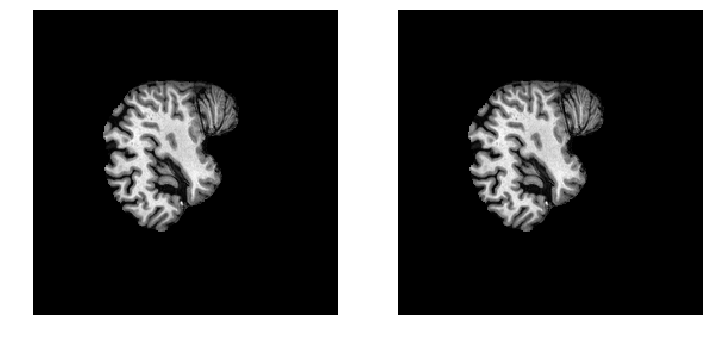

In [90]:
xn, yn = fl((im,im))
xn, yn = nm(xn), nm(yn)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn,ax1);show(yn,ax2)

### Test gamma (& gain) transform

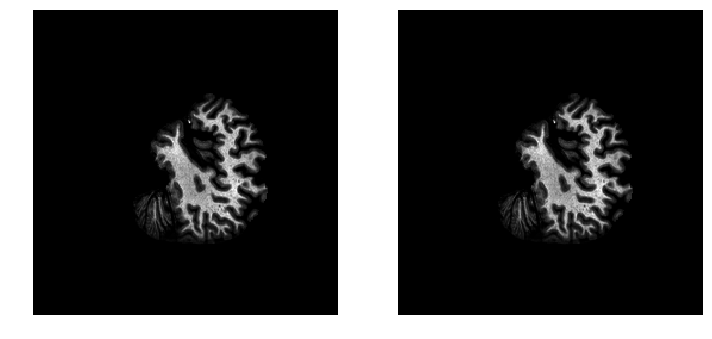

In [94]:
gm = RandomGamma(1, True, 2, 1)
xn,yn = gm((torch.tensor(np.asarray(im) + 1), torch.tensor(np.asarray(im) + 1)))
xn,yn = np.asarray(xn), np.asarray(yn)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn.squeeze(),ax1);show(yn.squeeze(),ax2)

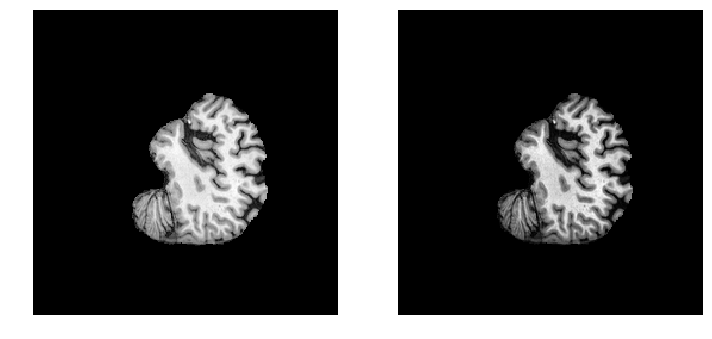

In [95]:
gm = RandomGamma(1, False, 1, 0)
xn,yn = gm((torch.tensor(np.asarray(im) + 1), torch.tensor(np.asarray(im) + 1)))
xn,yn = np.asarray(xn), np.asarray(yn)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn.squeeze(),ax1);show(yn.squeeze(),ax2)

### Add noise transform

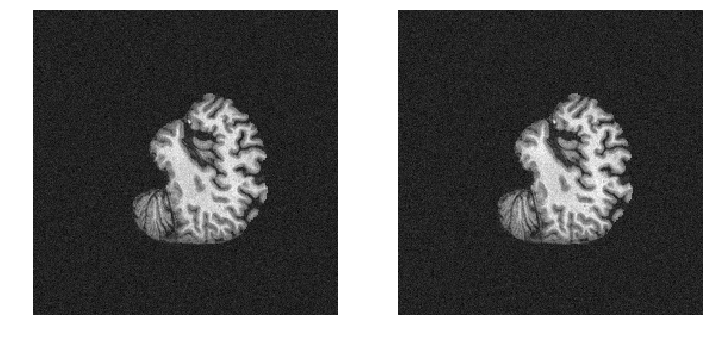

In [103]:
nz = RandomNoise(1, True, True, 50)
xn,yn = nz((torch.tensor(np.asarray(im) + 1), torch.tensor(np.asarray(im) + 1)))
xn,yn = np.asarray(xn), np.asarray(yn)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn.squeeze(),ax1);show(yn.squeeze(),ax2)

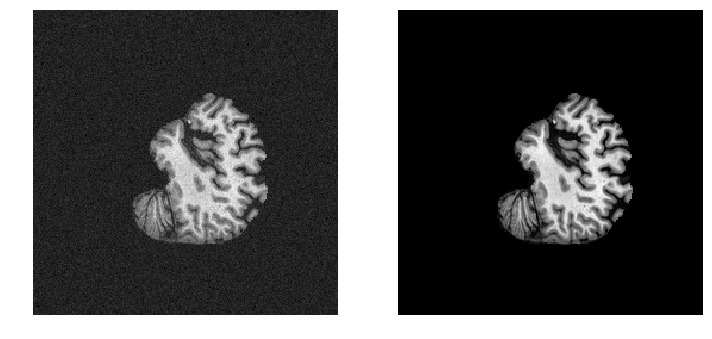

In [104]:
nz = RandomNoise(1, True,False, 50)
xn,yn = nz((torch.tensor(np.asarray(im) + 1), torch.tensor(np.asarray(im) + 1)))
xn,yn = np.asarray(xn), np.asarray(yn)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn.squeeze(),ax1);show(yn.squeeze(),ax2)

### Digitize transform

In [105]:
rng = (np.asarray(im).min(), np.asarray(im).max())
stp = (rng[1] - rng[0]) / 5

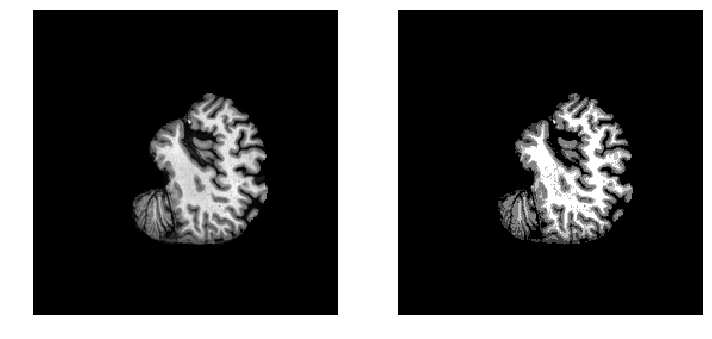

In [108]:
dg = Digitize(False, True, rng, stp)
xn,yn = dg((np.asarray(im), np.asarray(im)))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn.squeeze(),ax1); show(yn.squeeze(),ax2)

## Remove random block transform

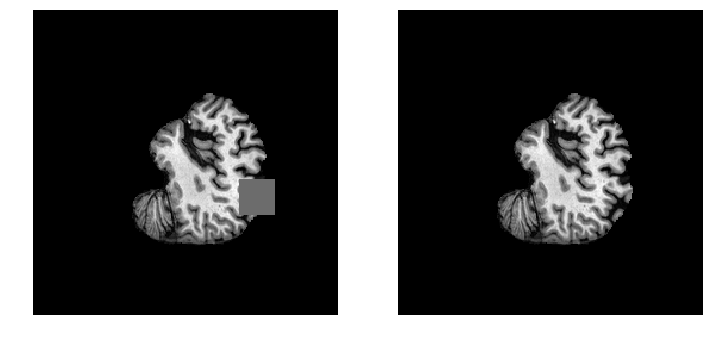

In [109]:
rb = RandomBlock(1, (30,40))
xn,yn = rb((np.array(im)[None,...], np.array(im)[None,...]))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
show(xn.squeeze(),ax1); show(yn.squeeze(),ax2)